## Import Libraries and Clean Data

In [1]:
import numpy as np 
import pandas as pd
import time

import scipy.stats as scs 
import statsmodels.api as sm


from sklearn.linear_model import LinearRegression, Ridge, Lasso 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo

%matplotlib inline

In [2]:
df = pd.read_csv("../data/cleaned_data.csv")

## Additional Cleaning
I need to remove index and id columns.
I am also going to create two new boolean variables:
* whether or not the house has a basement
* whether or not the house has been renovated
There will be two continuous variables as well:
* price/sqft = price / sqft_living
* bed_to_bath_ratio

In [3]:
# remove 'Unnamed:' index column from cleaned_data.csv
df.drop(df.columns[0], axis=1, inplace=True)
df.head()

id        date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  2014-10-13  221900.0         3       1.00         1180   
1  6414100192  2014-12-09  538000.0         3       2.25         2570   
2  5631500400  2015-02-25  180000.0         2       1.00          770   
3  2487200875  2014-12-09  604000.0         4       3.00         1960   
4  1954400510  2015-02-18  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  condition  grade  sqft_above  sqft_basement  \
0      5650     1.0         0.0          3      7        1180            0.0   
1      7242     2.0         0.0          3      7        2170          400.0   
2     10000     1.0         0.0          3      6         770            0.0   
3      5000     1.0         0.0          5      7        1050          910.0   
4      8080     1.0         0.0          3      8        1680            0.0   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0      1955           0.0    98178  47.5112 -122.257           1340   
1      1951        1991.0    98125  47.7210 -122.319           1690   
2      1933           0.0    98028  47.7379 -122.233           2720   
3      1965           0.0    98136  47.5208 -122.393           1360   
4      1987           0.0    98074  47.6168 -122.045           1800   

   sqft_lot15  
0        5650  
1        7639  
2        8062  
3        5000  
4        7503

In [4]:
#remove 'id' column as I don't inted to use it
df.drop(columns=['id'], inplace=True)
df.head()

date     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0  2014-10-13  221900.0         3       1.00         1180      5650     1.0   
1  2014-12-09  538000.0         3       2.25         2570      7242     2.0   
2  2015-02-25  180000.0         2       1.00          770     10000     1.0   
3  2014-12-09  604000.0         4       3.00         1960      5000     1.0   
4  2015-02-18  510000.0         3       2.00         1680      8080     1.0   

   waterfront  condition  grade  sqft_above  sqft_basement  yr_built  \
0         0.0          3      7        1180            0.0      1955   
1         0.0          3      7        2170          400.0      1951   
2         0.0          3      6         770            0.0      1933   
3         0.0          5      7        1050          910.0      1965   
4         0.0          3      8        1680            0.0      1987   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0           0.0    98178  47.5112 -122.257           1340        5650  
1        1991.0    98125  47.7210 -122.319           1690        7639  
2           0.0    98028  47.7379 -122.233           2720        8062  
3           0.0    98136  47.5208 -122.393           1360        5000  
4           0.0    98074  47.6168 -122.045           1800        7503

I am going to do some engineering and create two new columns.
 * renovated:  Indicates whether or not the home has been renovated
 * has_basement: Indicates whether or note the home has any square feet in the basement indicated

In [54]:
df.loc[df['yr_renovated'] > 0.0 , 'renovated'] = 1.0
df.loc[df['sqft_basement'] > 0.0 , 'has_basement'] = 1.0
df['price/sqft'] = df['price'] / df['sqft_living']
df['bed_to_bath_ratio'] = df['bedrooms'] / df['bathrooms']
df['renovated'] = df['renovated'].fillna(0.0)
df['has_basement'] = df['has_basement'].fillna(0.0)

In [51]:
df.head()

date     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0  2014-10-13  221900.0         3       1.00         1180      5650     1.0   
1  2014-12-09  538000.0         3       2.25         2570      7242     2.0   
2  2015-02-25  180000.0         2       1.00          770     10000     1.0   
3  2014-12-09  604000.0         4       3.00         1960      5000     1.0   
4  2015-02-18  510000.0         3       2.00         1680      8080     1.0   

   waterfront  condition  grade  ...  yr_renovated  zipcode      lat     long  \
0         0.0          3      7  ...           0.0    98178  47.5112 -122.257   
1         0.0          3      7  ...        1991.0    98125  47.7210 -122.319   
2         0.0          3      6  ...           0.0    98028  47.7379 -122.233   
3         0.0          5      7  ...           0.0    98136  47.5208 -122.393   
4         0.0          3      8  ...           0.0    98074  47.6168 -122.045   

   sqft_living15  sqft_lot15  renovated  has_basement  yrs_since_reno  \
0           1340        5650        0.0           0.0          2020.0   
1           1690        7639        1.0           1.0            29.0   
2           2720        8062        0.0           0.0          2020.0   
3           1360        5000        0.0           1.0          2020.0   
4           1800        7503        0.0           0.0          2020.0   

   price/sqft  
0  188.050847  
1  209.338521  
2  233.766234  
3  308.163265  
4  303.571429  

[5 rows x 23 columns]

## Exploratory Data Analysis
The goal is to asses if there are interesting relationships between variables.  I will look at how the data is distributed and whether there are potential correlations between variables.  

### Inserting/creating new variables

In [59]:
#create two groups of variables in order to visualize them seperately.
# a third variable is created to analyze all
continuous = ['price','sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built','date', 'bed_to_bath_ratio','price/sqft']
categorical = ['bedrooms', 'bathrooms', 'floors', 'zipcode', 'grade', 'condition', 'waterfront', 'renovated', 'has_basement']
all_variables = ['price','sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built','date',
               'bedrooms', 'bathrooms', 'floors', 'zipcode', 'grade', 'condition', 'waterfront', 'renovated', 'has_basement','bed_to_bath_ratio','price/sqft']

### A look at all the data in general

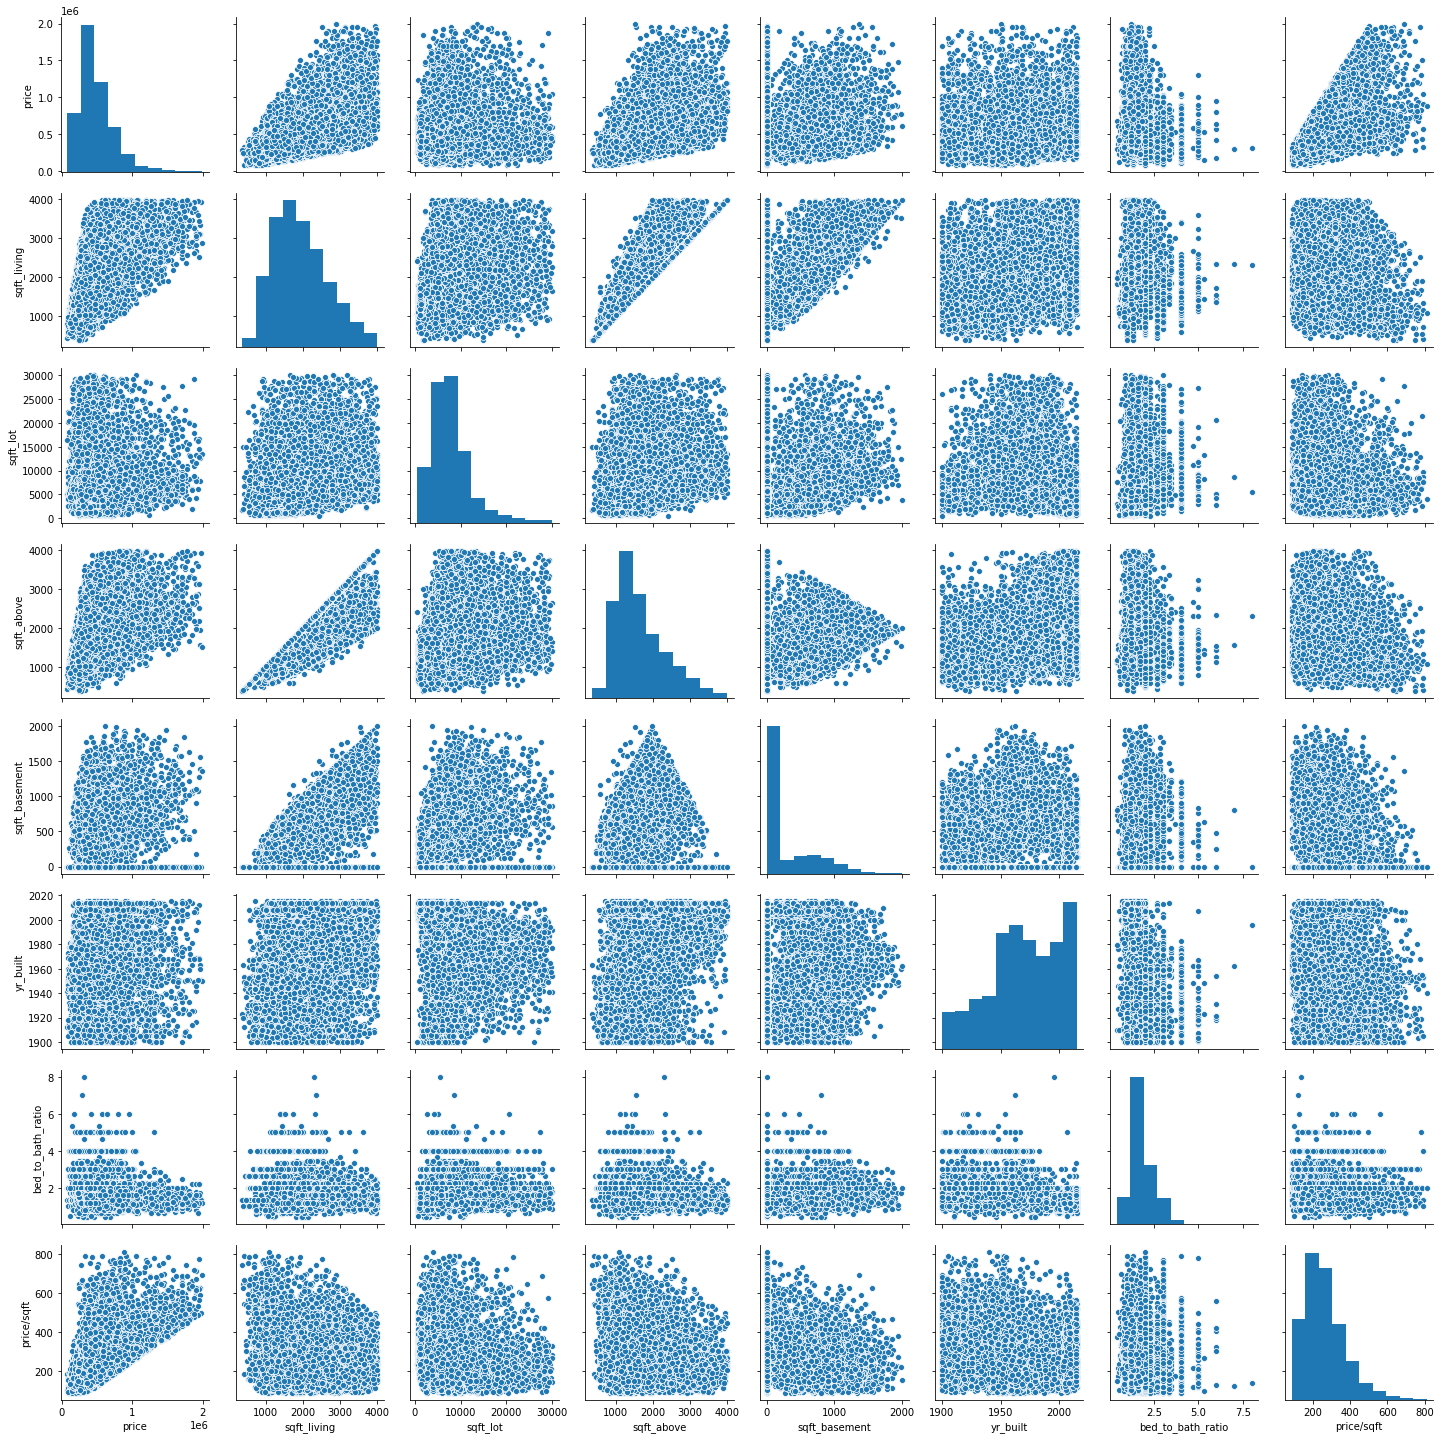

In [60]:
sns.pairplot(df[continuous])

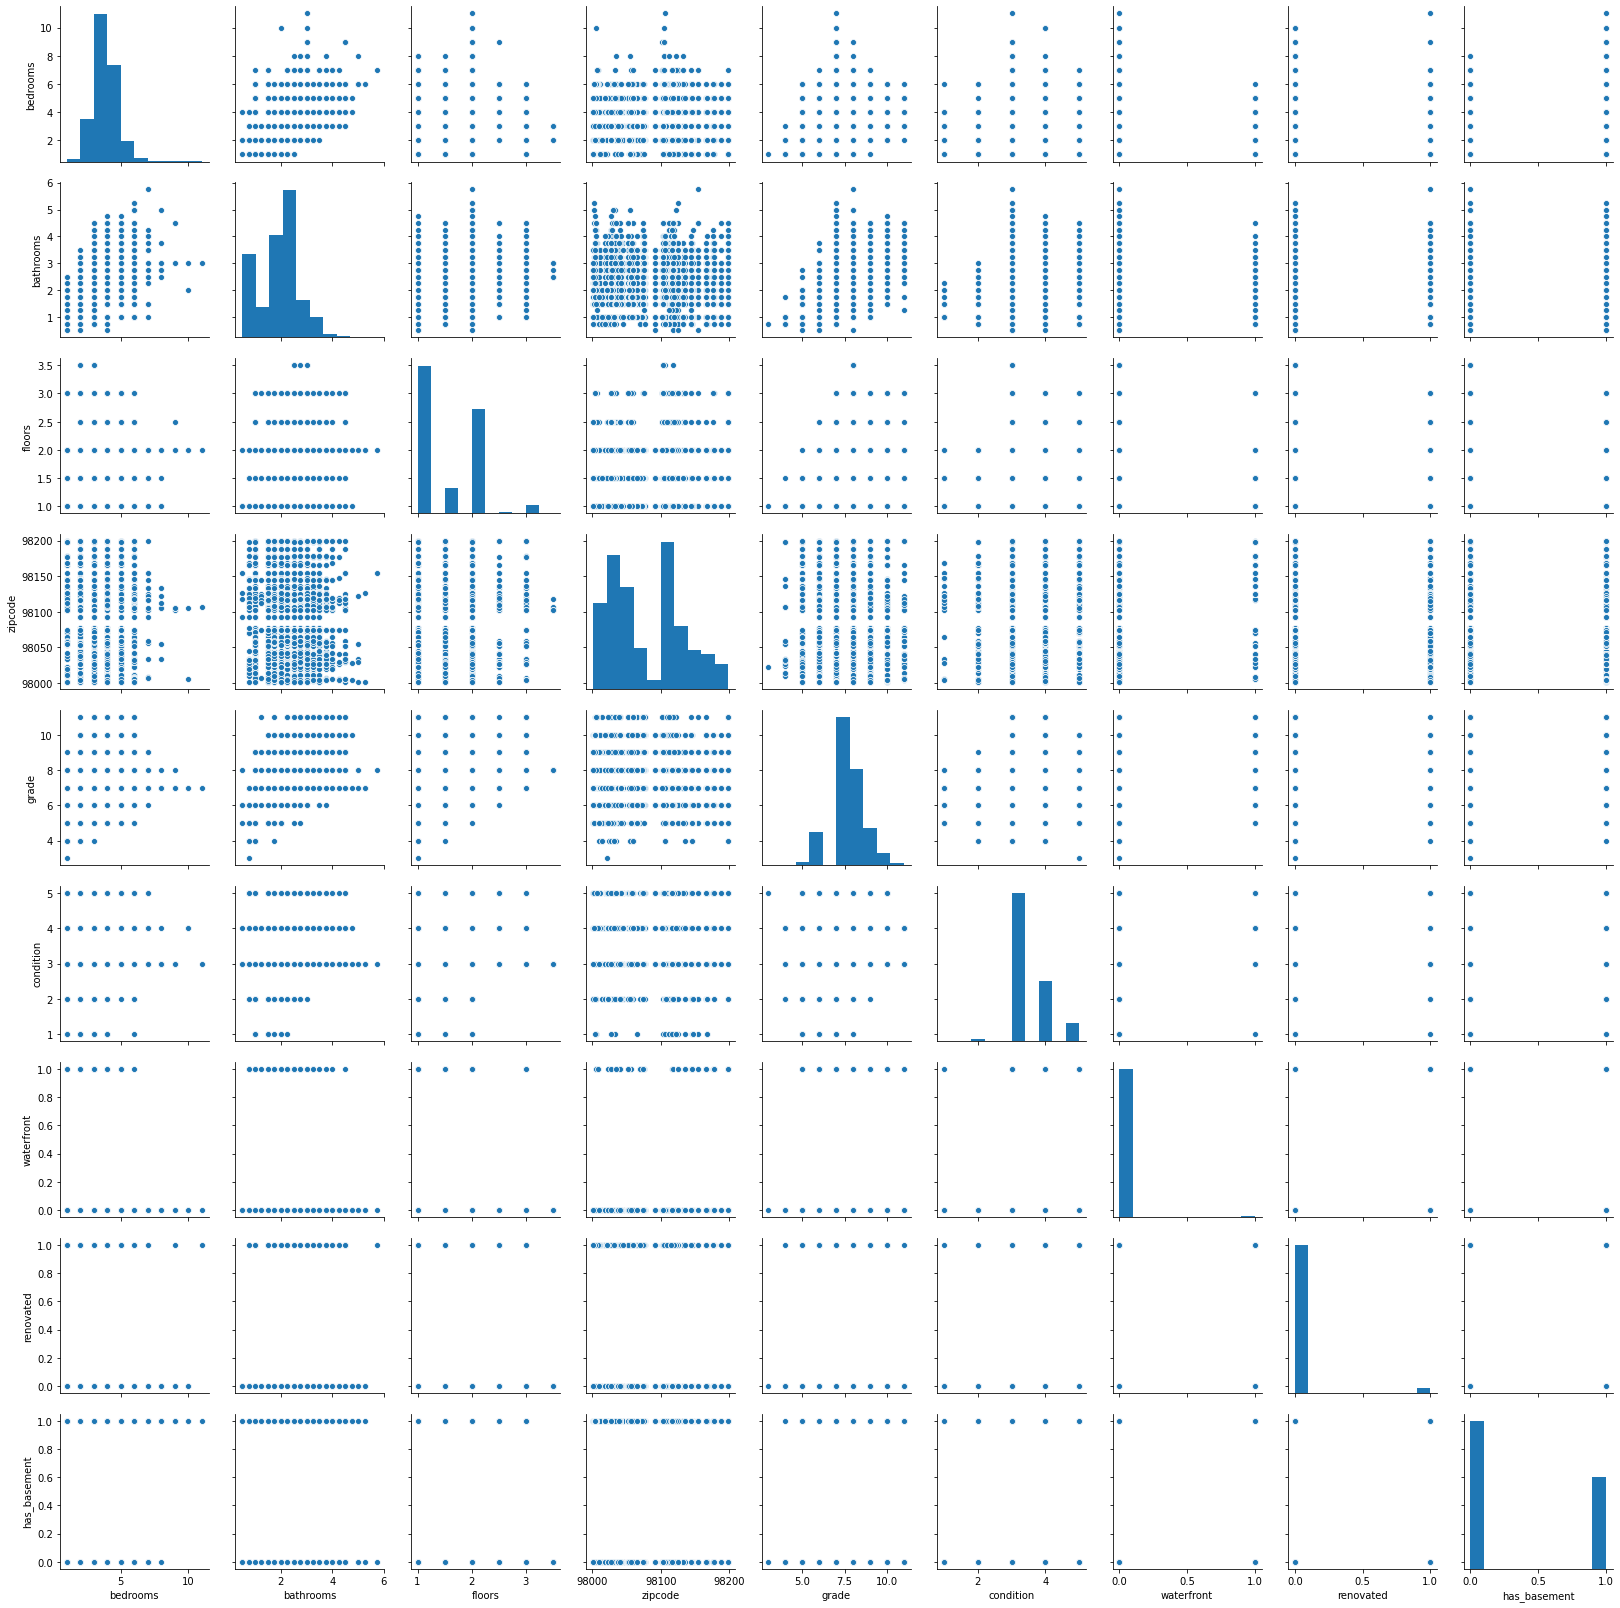

In [61]:
sns.pairplot(df[categorical])

In [62]:
#lets look at the correlation matrices for all variables.
#Looking for multicollinearity and variables that may help predict price
matrix = df[all_variables].corr()
matrix

price  sqft_living  sqft_lot  sqft_above  sqft_basement  \
price              1.000000     0.613178  0.060069    0.495029       0.267249   
sqft_living        0.613178     1.000000  0.230812    0.836983       0.385249   
sqft_lot           0.060069     0.230812  1.000000    0.188705       0.096139   
sqft_above         0.495029     0.836983  0.188705    1.000000      -0.173578   
sqft_basement      0.267249     0.385249  0.096139   -0.173578       1.000000   
yr_built          -0.002278     0.316762 -0.030858    0.440954      -0.168680   
bedrooms           0.283691     0.613073  0.172276    0.485339       0.278534   
bathrooms          0.435792     0.711535  0.005510    0.627500       0.220189   
floors             0.250291     0.337299 -0.277792    0.538464      -0.294540   
zipcode           -0.004129    -0.187114 -0.229406   -0.265747       0.109047   
grade              0.626581     0.698740  0.096136    0.690444       0.093701   
condition          0.067500    -0.049023  0.094939   -0.168523       0.189513   
waterfront         0.154317     0.031573  0.098655    0.011401       0.036479   
renovated          0.117101     0.044141  0.009311    0.013489       0.056001   
has_basement       0.191118     0.203238 -0.013951   -0.273282       0.841070   
bed_to_bath_ratio -0.226600    -0.294872  0.100929   -0.284080      -0.052762   
price/sqft         0.579222    -0.210838 -0.181983   -0.189323      -0.059504   

                   yr_built  bedrooms  bathrooms    floors   zipcode  \
price             -0.002278  0.283691   0.435792  0.250291 -0.004129   
sqft_living        0.316762  0.613073   0.711535  0.337299 -0.187114   
sqft_lot          -0.030858  0.172276   0.005510 -0.277792 -0.229406   
sqft_above         0.440954  0.485339   0.627500  0.538464 -0.265747   
sqft_basement     -0.168680  0.278534   0.220189 -0.294540  0.109047   
yr_built           1.000000  0.150338   0.521852  0.499067 -0.343066   
bedrooms           0.150338  1.000000   0.497470  0.154400 -0.157900   
bathrooms          0.521852  0.497470   1.000000  0.507751 -0.198201   
floors             0.499067  0.154400   0.507751  1.000000 -0.057579   
zipcode           -0.343066 -0.157900  -0.198201 -0.057579  1.000000   
grade              0.453382  0.324215   0.607516  0.456966 -0.168483   
condition         -0.359370  0.031263  -0.127108 -0.272362 -0.007039   
waterfront        -0.032771 -0.021632   0.013358  0.006427  0.040107   
renovated         -0.199686  0.014226   0.042676  0.005270  0.067550   
has_basement      -0.171791  0.148454   0.148640 -0.268579  0.171549   
bed_to_bath_ratio -0.433706  0.215111  -0.673457 -0.376350  0.116859   
price/sqft        -0.317299 -0.260849  -0.168237 -0.009818  0.194597   

                      grade  condition  waterfront  renovated  has_basement  \
price              0.626581   0.067500    0.154317   0.117101      0.191118   
sqft_living        0.698740  -0.049023    0.031573   0.044141      0.203238   
sqft_lot           0.096136   0.094939    0.098655   0.009311     -0.013951   
sqft_above         0.690444  -0.168523    0.011401   0.013489     -0.273282   
sqft_basement      0.093701   0.189513    0.036479   0.056001      0.841070   
yr_built           0.453382  -0.359370   -0.032771  -0.199686     -0.171791   
bedrooms           0.324215   0.031263   -0.021632   0.014226      0.148454   
bathrooms          0.607516  -0.127108    0.013358   0.042676      0.148640   
floors             0.456966  -0.272362    0.006427   0.005270     -0.268579   
zipcode           -0.168483  -0.007039    0.040107   0.067550      0.171549   
grade              1.000000  -0.152007    0.034265   0.009219      0.035966   
condition         -0.152007   1.000000    0.017019  -0.056479      0.130953   
waterfront         0.034265   0.017019    1.000000   0.066221      0.022068   
renovated          0.009219  -0.056479    0.066221   1.000000      0.039879   
has_basement       0.035966   0.130953    0.022068   0.039879      1.000000   
be

Interestingly none of the variables seem to have a significant correlation to price/sqft.  I thought grade, condition, waterfront and bed/bath ratio would have a positive correlation to price/sqft.

### Taking a Closer Look at Price
A more focused analysis on variables that have more than a plus or minus 0.20 correlation to price

In [23]:
#pricefoi - features of interest when analyzing correlation to price.  
pricefoi = ['price', 'sqft_living', 'grade', 'sqft_above', 'bathrooms', 'bedrooms', 'sqft_basement', 'floors', 'bed_to_bath_ratio']

In [24]:
foimatrix = df[pricefoi].corr()
foimatrix

price  sqft_living     grade  sqft_above  bathrooms  \
price          1.000000     0.613178  0.626581    0.495029   0.435792   
sqft_living    0.613178     1.000000  0.698740    0.836983   0.711535   
grade          0.626581     0.698740  1.000000    0.690444   0.607516   
sqft_above     0.495029     0.836983  0.690444    1.000000   0.627500   
bathrooms      0.435792     0.711535  0.607516    0.627500   1.000000   
bedrooms       0.283691     0.613073  0.324215    0.485339   0.497470   
sqft_basement  0.267249     0.385249  0.093701   -0.173578   0.220189   
floors         0.250291     0.337299  0.456966    0.538464   0.507751   

               bedrooms  sqft_basement    floors  
price          0.283691       0.267249  0.250291  
sqft_living    0.613073       0.385249  0.337299  
grade          0.324215       0.093701  0.456966  
sqft_above     0.485339      -0.173578  0.538464  
bathrooms      0.497470       0.220189  0.507751  
bedrooms       1.000000       0.278534  0.154400  
sqft_basement  0.278534       1.000000 -0.294540  
floors         0.154400      -0.294540  1.000000

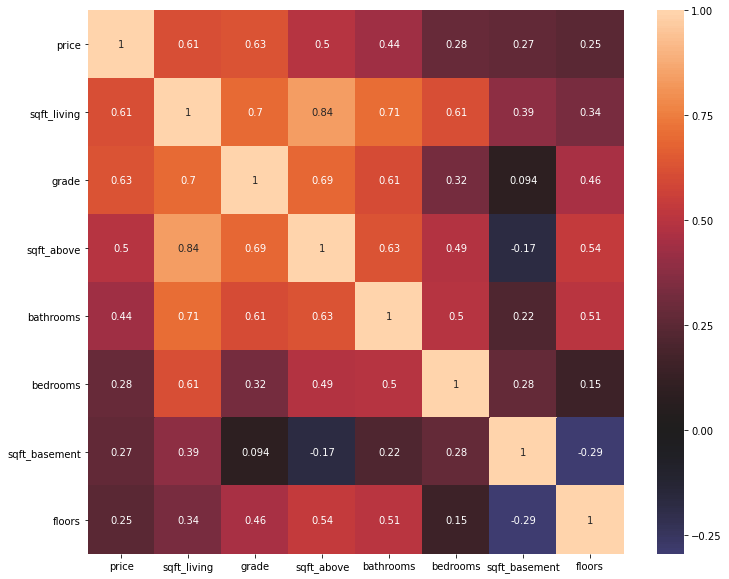

In [25]:
#Adding some color
plt.figure(figsize=(12,10))
sns.heatmap(foimatrix, center=0, annot=True);

#### Price and Sqft_living

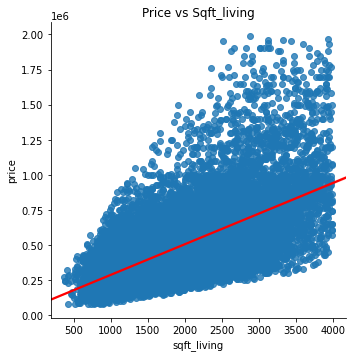

In [37]:
#closer look at price vs sqft_living.  This relationship is obvious and intuitive...
#...the bigger the house the higher the price
sns.lmplot(x='sqft_living', y='price', data=df, line_kws={'color': 'red'})
plt.title("Price vs Sqft_living".format('price', 'sqft_living'))
plt.show()

#### The relationship between price and grade

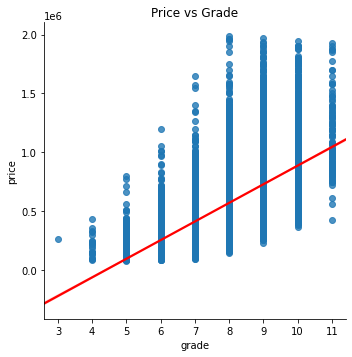

In [40]:
#higher grade equates to higher price. Makes sense
sns.lmplot(x='grade', y='price', data=df, line_kws={'color': 'red'})
plt.title("Price vs Grade".format('price', 'grade'))
plt.show()

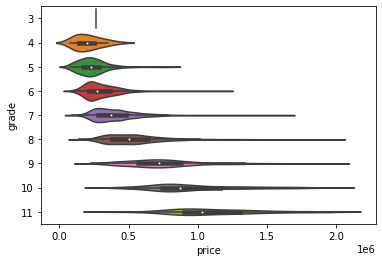

In [46]:
#I'll use a violin plot to show the dispersion of price in each grade category
sns.violinplot(x='price', y='grade', data=df, orient='h')
plt.show()

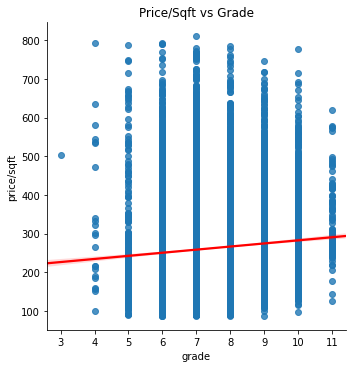

In [52]:
#A more precise question would be "how does grade affect price/sqft"
sns.lmplot(x='grade', y='price/sqft', data=df, line_kws={'color': 'red'})
plt.title("Price/Sqft vs Grade".format('price/sqft', 'grade'))
plt.show()

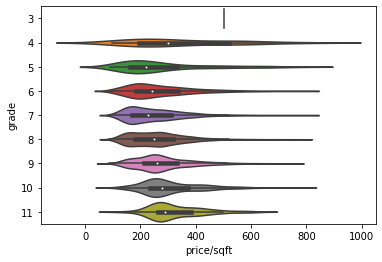

In [53]:
#Again, a violin plot to show the dispersion of price/sqft in each grade category
#The relationship is not as clear.  There must be a lot of noise another factor impacting price/sqft
sns.violinplot(x='price/sqft', y='grade', data=df, orient='h')
plt.show()

For context, here are the definitions of each grade from the King Country grading system:

1-3 Falls short of minimum building standards. Normally cabin or inferior structure.

4 Generally older, low quality construction. Does not meet code.

5 Low construction costs and workmanship. Small, simple design.

6 Lowest grade currently meeting building code. Low quality materials and simple designs.

7 Average grade of construction and design. Commonly seen in plats and older sub-divisions.

8 Just above average in construction and design. Usually better materials in both the exterior and interior finish work.

9 Better architectural design with extra interior and exterior design and quality.

10 Homes of this quality generally have high quality features. Finish work is better and more design quality is seen in the floor plans. Generally have a larger square footage.

11 Custom design and higher quality finish work with added amenities of solid woods, bathroom fixtures and more luxurious options.

12 Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.

13 Generally custom designed and built. Mansion level. Large amount of highest quality cabinet work, wood trim, marble, entry ways etc.

#### The relationship between price and number of bathrooms
There is a positive relationship between price and the number of bathrooms

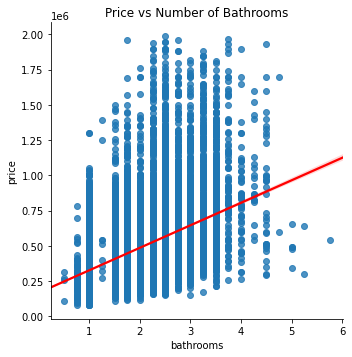

In [42]:
sns.lmplot(x='bathrooms', y='price', data=df, line_kws={'color': 'red'})
plt.title("Price vs Number of Bathrooms".format('price', 'bathrooms'))
plt.show()

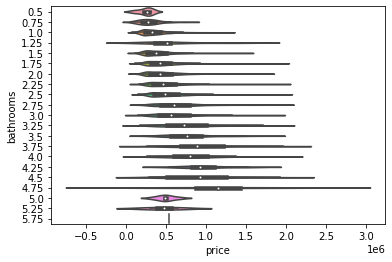

In [64]:
sns.violinplot(x='price', y='bathrooms', data=df, orient='h')
plt.show()

#### The relationship between price and bed/bath ratio
Intuitively the more bedrooms that share a bathroom the lower the price of the house.  This hypothesis is correct

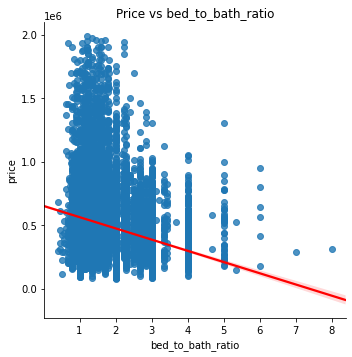

In [65]:
sns.lmplot(x='bed_to_bath_ratio', y='price', data=df, line_kws={'color': 'red'})
plt.title("Price vs bed_to_bath_ratio".format('price', 'bed_to_bath_ratio'))
plt.show()

#### The relationship between price and location
Rather than fiddle with a correlation matrix I decided to graph price on top of longitude and latitude.  

Text(0.5, 1.0, 'Price by Location')

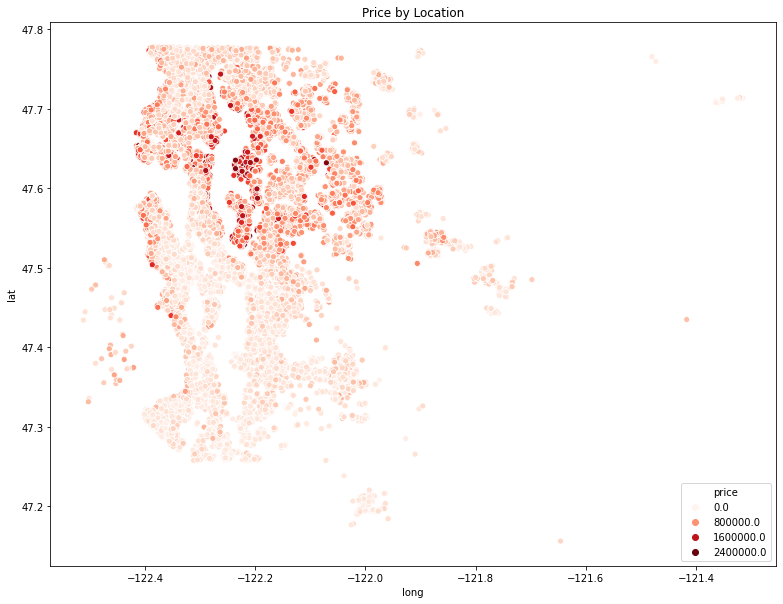

In [66]:
# A look at price verus location
plt.figure(figsize=(13,10))
sns.scatterplot(df['long'], df['lat\
'], hue=df['price'], palette='Reds')
plt.legend(loc='lower right')
plt.title("Price by Location")

By comparing the longitude and latitude heat map with the it looks like zip code 98033, 98039, 98004 and 98040 have the highest priced Real estate.  These are all clustered around Lake Washington  

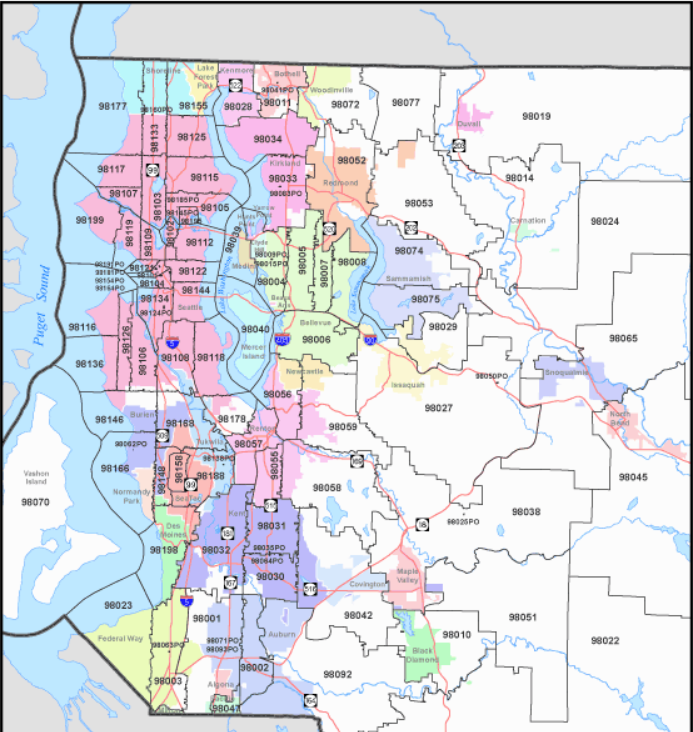

Text(0.5, 1.0, 'Price vs Having a Basement')

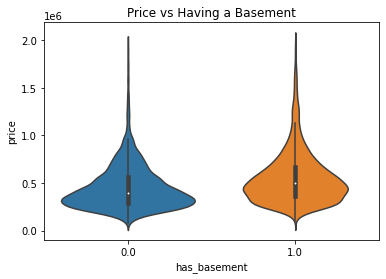

In [34]:
#There does not appear to be a remarkable relationship between price and whether or not there is a basement
sns.violinplot(x=df['has_basement'],y=df['price'])
plt.title("Price vs Having a Basement")

<Figure size 936x576 with 0 Axes>

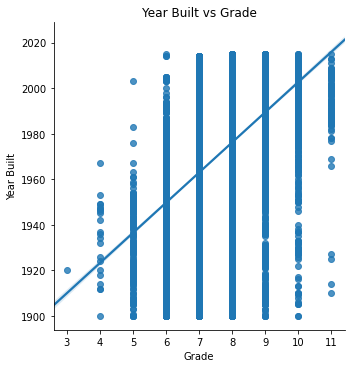

In [29]:
plt.figure(figsize=(13,8))
sns.lmplot(x='grade',y='yr_built',data=df)
ax = plt.gca()
ax.set(xlabel='Grade', ylabel='Year Built', title="Year Built vs Grade")
plt.show();